# MuSLIT : Multi-band Sparse Linear Inversion Tool

Preliminary tests for an adaptation of principle of SLIT in the formulation of non-negative matrix factorization (NMF). 

We first make use of the following libraries, at least for these tests :
- **PySAP** for efficient wavelet transforms
- **proxmin** for NMF optimizer (Block-SDMM)

_some $\LaTeX$ definitions_
$\newcommand{\mat}[1]{\mathsf{#1}}$
$\newcommand{\matind}[2]{\mathsf{#1}_{#2}}$
$\newcommand{\RoneD}[1]{\mathbb{R}^{#1}}$
$\newcommand{\RtwoD}[2]{\mathbb{R}^{#1\times#2}}$
$\newcommand{\RthreeD}[3]{\mathbb{R}^{#1\times#2\time#3}}$
$\newcommand{\Nps}{N_\mathrm{p,\,s}}$
$\newcommand{\Npi}{N_\mathrm{p,\,i}}$
$\newcommand{\Np}{N_\mathrm{p}}$
$\newcommand{\Nb}{N_\mathrm{b}}$
$\newcommand{\Ns}{N_\mathrm{s}}$
$\newcommand{\ie}{\emph{i.e.}}$
$\newcommand{\atiter}[1]{^{(#1)}}$
$\newcommand{\Niter}{N_{\mathrm{iter}}}$
$\newcommand{\Nsubiter}{N_{\mathrm{subiter}}}$
$\newcommand{\FISTA}[1]{\mathrm{FISTA}(#1)}$
$\newcommand{\normzero}[1]{\left\lVert #1 \right\rVert_0}$
$\newcommand{\normone}[1]{\left\lVert #1 \right\rVert_1}$
$\newcommand{\normtwo}[1]{\left\lVert #1 \right\rVert_2}$
$\newcommand{\fidelity}{\mathcal{D} \left( \mat{Y}\, |\, \mat{A_S},\, \mat{A_G},\, \mat{S},\, \mat{G} \right)}$

$\renewcommand{\algorithmicrequire}{\textbf{Input:}}$
$\renewcommand{\algorithmicensure}{\textbf{Output:}}$

$\DeclareMathOperator*{\argmin}{arg\,min}$

## Problem statement (ignoring PSF for now)

The problem we want to solve can be written as the following minimizatiton problem, with forward model $\mat{Y}=\mat{A\,S}$.

- Synthesis formulation :
\begin{align}
        \argmin_{\mat{A},\,\alpha_\mat{G},\,\alpha_\mat{S}}&\ \normtwo{\mat{Y}-\mat{A}
        \begin{bmatrix}
            \left(\mat{F_\kappa}\Phi^\top\alpha_\mat{S}\right)^\top \\
            \left(\Phi^\top\alpha_\mat{G}\right)^\top
        \end{bmatrix}
        }^2 + i_{\cdot\geq0}\!\left(\mat{A}\right) + i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{S}\right) + i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{G}\right) + g_1\!\left(\mat{A}\right) + \lambda_\mat{S}\normzero{\alpha_\mat{S}} + \lambda_\mat{G}\normzero{\alpha_\mat{G}}
\end{align}


- Analysis formulation (preferred, but no prox for $\normzero{\Phi\mat{X}}$ !!) :
\begin{align}
        \label{eq:final_eq_analysis}
        \argmin_{\mat{A},\,\mat{G},\,\mat{S}}&\ \normtwo{\mat{Y}-\mat{A}
        \begin{bmatrix}
            \left(\mat{F_\kappa}\mat{S}\right)^\top \\
            \mat{G}^\top
        \end{bmatrix}
        }^2 + i_{\cdot\geq0}\!\left(\mat{A}\right) + i_{\cdot\geq0}\!\left(\mat{S}\right) + i_{\cdot\geq0}\!\left(\mat{G}\right) + g_1\!\left(\mat{A}\right) + \lambda_\mat{S}\normzero{\alpha_\mat{S}} + \lambda_\mat{G}\normzero{\alpha_\mat{G}}
\end{align}

For implementation practicity, the constraint $i_{\cdot\geq0}\!\left(\Phi^\top\alpha_\mat{S}\right)$ may be applied as $i_{\cdot\geq0}\!\left(\mat{F_\kappa}\Phi^\top\alpha_\mat{S}\right)$. Both formulations are equivalent, since $\mat{F_\kappa}$ is non-negative.

#### Adding the PSF convolution

The forward model becomes $\mat{Y}=\mat{H}*\mat{A\,S}$, with $\mat{H}*\cdot$ being the PSF convolution in each band :
\begin{align}
        \mat{H} =
        \begin{bmatrix}
            \mat{H_1} & & \\
             & \ddots & \\
             & & \mat{H}_{\Nb}
        \end{bmatrix}
\end{align}

In [1]:
import os
import sys
import PIL
import copy
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

from pylensmodels.utils import coordinates
from pylensmodels.mass.spemd import SPEMD_glee
from pylensmodels.light.gaussian import Gaussian, GaussianElliptical
from MuSLIT.lensing import planes
from MuSLIT.utils.plot import nice_colorbar
from MuSLIT.MuSLIT import LightModeller

lin = lambda x: x
log = lambda x: np.log10(x)

PySAP Package version: 0.0.3




# 1. Generate a mass model
Simple SPEMD profile, using GLEE parameter conventions

In [2]:
num_pix = 100
x_grid, y_grid = coordinates.square_grid(num_pix)
print(x_grid, y_grid)

#extra_num_pix = 3000
#x_grid_large, y_grid_large = coordinates.square_grid(num_pix + extra_num_pix)

source_to_image_ratio = 1
num_pix_src = num_pix * source_to_image_ratio

[ 0.  1.  2. ... 97. 98. 99.] [ 0.  0.  0. ... 99. 99. 99.]


In [3]:
kwargs_spemd = {
    'x0': 50.5,  # pixels (origin : lower left pixel)
    'y0': 50.5,  # pixels (origin : lower left pixel)
    'gamma': 0.3,
    'theta_E': 25.,  # pixels
    'q': 0.8,
    'phi': 0.3,
    'r_core': 0.01,  # pixels
}

# WARNING : no Dds/Ds (physical to scaled conversion) scaling
mass_model = SPEMD_glee(kwargs_spemd, Dds_Ds=None)
kappa = mass_model.convergence(x_grid, y_grid)
alpha1, alpha2 = mass_model.deflection(x_grid, y_grid)

#kwargs_spemd_large = copy.deepcopy(kwargs_spemd)
#kwargs_spemd_large['x0'] = kwargs_spemd['x0'] + extra_num_pix/2
#kwargs_spemd_large['y0'] = kwargs_spemd['y0'] + extra_num_pix/2
#kappa_large = mass_model_large.convergence(x_grid_large, y_grid_large)
#mass_model_large = SPEMD_glee(kwargs_spemd_large, Dds_Ds=None)

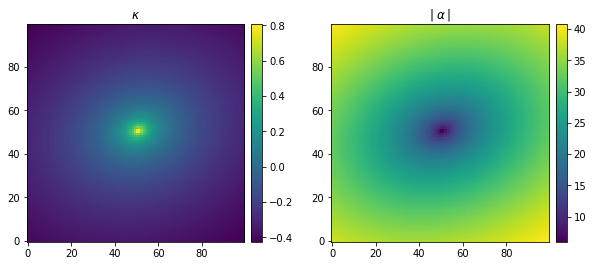

In [4]:
ax = plt.subplot2grid((1, 2), (0, 0), fig=plt.figure(figsize=(10, 4)))
im = ax.imshow(np.log10(kappa), origin='lower')
ax.set_title("$\kappa$")
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
im = ax.imshow(np.sqrt(alpha1**2+alpha2**2), origin='lower')
ax.set_title(r"$|\ \alpha\,|$")
nice_colorbar(im)
plt.show()

Deflection angles have been provided
<class 'list'> 10000


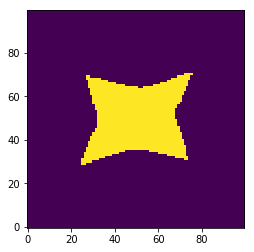

In [5]:
lensing_operator = planes.build_lensing_operator(None, num_pix, source_to_image_ratio, 
                                                 alpha_x_in=alpha1, alpha_y_in=alpha2)
print(type(lensing_operator), len(lensing_operator))
#lensing_operator_kappa = planes.build_lensing_operator(kappa_large, num_pix, source_to_image_ratio)

image_ones = np.ones((num_pix, num_pix))
source_ones = planes.image_to_source(image_ones, lensing_operator, num_pix_src)
#source_ones_kappa = planes.image_to_source(image_ones, lensing_operator_kappa, num_pix_src)

plt.imshow(source_ones, origin='lower')
plt.show()

# 2. Simulate a single-band image

In [6]:
kwargs_gaussian_ell = {'x0': 50, 'y0': 50, 'sigma': 2, 'phi': 0.3, 'q': 0.6, 'amp': 1}
gaussian_source = GaussianElliptical(kwargs_gaussian_ell).function(x_grid, y_grid)

kwargs_gaussian = {'x0': 50, 'y0': 50, 'sigma_x': 8, 'sigma_y': 8, 'amp': 7}
gaussian_lens = Gaussian(kwargs_gaussian).function(x_grid, y_grid)

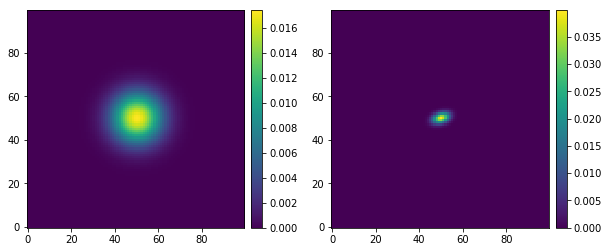

In [7]:
ax = plt.subplot2grid((1, 2), (0, 0), fig=plt.figure(figsize=(10, 4)))
im= ax.imshow(gaussian_lens, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1))
im= ax.imshow(gaussian_source, origin='lower')
nice_colorbar(im)

plt.show()

In [8]:
#data_dir = '/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Lens_modelling/gravlensgen/Data/various_images'
#galaxy_source = pyfits.open(os.path.join(data_dir, 'M81_HST_prepared_n100.fits'))[0].data
#print(galaxy_source.shape)
#
#plt.imshow(galaxy_source, origin='lower')
#plt.colorbar()
#plt.show()

In [9]:
# normalization
galaxy_source = gaussian_source/gaussian_source.max()
galaxy_lens   = gaussian_lens/gaussian_lens.max()

In [10]:
galaxy_lensed = planes.source_to_image(galaxy_source, lensing_operator, num_pix)
print(galaxy_lensed.max())

galaxy_unlensed = planes.image_to_source(galaxy_lensed, lensing_operator, num_pix_src)
print(galaxy_unlensed.max())

1.0
0.9999999999999998


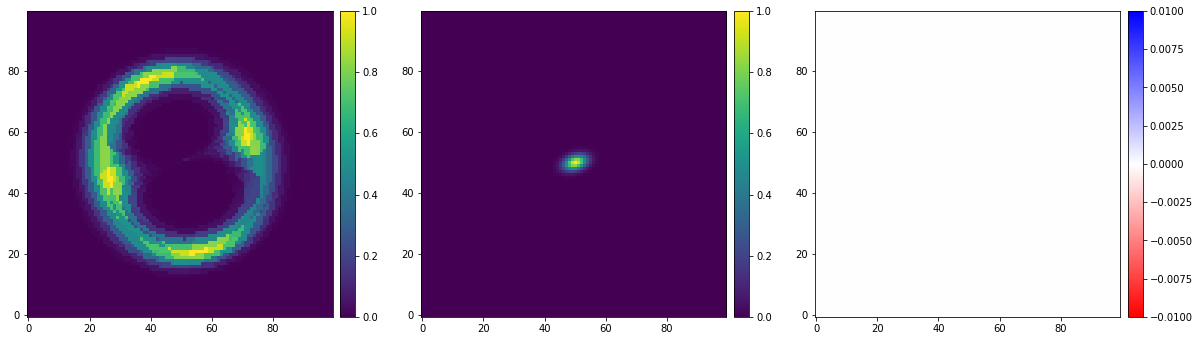

In [11]:
ax = plt.subplot2grid((1, 3), (0, 0), fig=plt.figure(figsize=(20, 6)))
im = ax.imshow(galaxy_lensed, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
im = ax.imshow(galaxy_unlensed, origin='lower')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
im = ax.imshow(galaxy_source-galaxy_unlensed, origin='lower', cmap='bwr_r', vmin=-0.01, vmax=0.01)
nice_colorbar(im)
plt.show()

In [12]:
sim_lens_base = galaxy_lensed + galaxy_lens

# 3. Generate a multi(3)-band image

In [13]:
def bands2image(band_list):
    return np.stack(band_list, axis=2)

def plot_rgb_bands(color_image_np):
    band_r = color_image_np[:,:,0]
    band_g = color_image_np[:,:,1]
    band_b = color_image_np[:,:,2]
    vmax = max((band_r.max(), band_g.max(), band_b.max()))
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    ax = axes[0]
    im = ax.imshow(band_r, origin='lower', cmap='Reds_r', vmax=vmax)
    #fig.colorbar(im, ax=ax)
    ax = axes[1]
    ax.imshow(band_g, origin='lower', cmap='Greens_r', vmax=vmax)
    ax = axes[2]
    ax.imshow(band_b, origin='lower', cmap='Blues_r', vmax=vmax)
    ax = axes[3]
    ax.imshow(lin(color_image_np), origin='lower')
    plt.show()

## Define spectral energy distributions

In [14]:
lens_SEDs   = (1.0, 0.9, 0.8)   # not normalized
source_SEDs = (0.6, 0.7, 0.8)   # not normalized

lens_multiband = [galaxy_lens * sed for sed in lens_SEDs]
lens_multiband = bands2image(lens_multiband)

lensed_multiband = [planes.source_to_image(galaxy_source*sed, lensing_operator, num_pix) for sed in source_SEDs]
lensed_multiband = bands2image(lensed_multiband)

In [15]:
sim_lens_multiband_no_noise = lens_multiband + lensed_multiband

## Add noise
_Only gaussian for simplicity_

In [16]:
noise1 = np.random.randn(num_pix, num_pix) * 0.05  # arbitrary units for now
noise2 = np.random.randn(num_pix, num_pix) * 0.05
noise3 = np.random.randn(num_pix, num_pix) * 0.05
noise_multiband = bands2image([noise1, noise2, noise3])

sim_lens_multiband = sim_lens_multiband_no_noise + noise_multiband

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


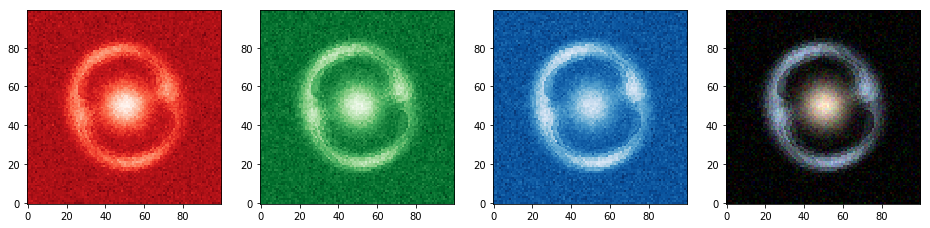

In [17]:
plot_rgb_bands(sim_lens_multiband)

# 4. Run _MuSLIT_ on it

In [18]:
target_image = np.transpose(sim_lens_multiband)
print(target_image.shape)

(3, 100, 100)


In [19]:
modeller = LightModeller(target_image, lensing_operator, threshold=10, starlet_level=4, 
                         source_to_image_ratio=source_to_image_ratio)
sys.exit()

In [20]:
modeller.run()

SHAPES T (100, 100) (100, 100)
SHAPES (100,) (100,)


IndexError: too many indices for array